#MIT Deep Learning lab 1

In [ ]:
#!pip install comet_ml > /dev/null 2>&1
import comet_ml

COMET_API_KEY = "0vx4mKznYdC8BUPzQHwH63GWb"


import tensorflow as tf

# Download and import the MIT Introduction to Deep Learning package
#!pip install mitdeeplearning --quiet
import mitdeeplearning as mdl

import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
from scipy.io.wavfile import write
!apt-get install abcmidi timidity > /dev/null 2>&1

# Check that we are using a GPU, if not switch runtimes
assert len(tf.config.list_physical_devices('GPU')) > 0
print(tf.config.list_physical_devices('GPU'))
assert COMET_API_KEY != "", "Please insert your Comet API Key"

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


 ## A dataset of thousands of Irish folk songs, represented in the ABC notation.

In [ ]:
# Download the dataset
songs = mdl.lab1.load_training_data()

# Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(example_song)

Found 817 songs in text

Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


In [ ]:
# Convert the ABC notation to audio file and listen to it
mdl.lab1.play_song(example_song)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
songs_joined = "\n\n".join(songs) #Şarkıları tek bir liste haline getiriyoruz ve her biri arasında 2 satır boşluk bırakıyoruz

#Listedeki harf, rakam, noktalama işaretleri, boşluklar gibi karakterleri alır ve bunları alfabetik sıralar.
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


## Process the dataset for the learning task
We're trying to train a RNN model to learn patterns in ABC music, and then use this model to generate (i.e., predict) a new piece of music based on this learned information.

what we're really asking the model is: given a character, or a sequence of characters, what is the most probable next character? We'll train the model to perform this task.

To achieve this, we will input a sequence of characters to the model, and train the model to predict the output, that is, the following character at each time step. RNNs maintain an internal state that depends on previously seen elements, so information about all characters seen up until a given moment will be taken into account in generating the prediction.

## Vectorize the text

In [ ]:
char2idx = {u:i for i, u in enumerate(vocab)} #karakter -> index sözlüğü oluşturuyor. Mesela char2idx['d'] dersem (örneğin)10 verecek. Modelin öğrenmesi için önemli çünkü string okuyamaz.

idx2char = np.array(vocab) #index -> karakter. Mesela idx2char[10] dersem 'd' verecek. Modelin bize anlamlı bir şey üretmesi için önemli.

In [ ]:
print('{')
for char,_ in zip(char2idx, range(len(char2idx))):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))


{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  '8' :  20,
  '9' :  21,
  ':' :  22,
  '<' :  23,
  '=' :  24,
  '>' :  25,
  'A' :  26,
  'B' :  27,
  'C' :  28,
  'D' :  29,
  'E' :  30,
  'F' :  31,
  'G' :  32,
  'H' :  33,
  'I' :  34,
  'J' :  35,
  'K' :  36,
  'L' :  37,
  'M' :  38,
  'N' :  39,
  'O' :  40,
  'P' :  41,
  'Q' :  42,
  'R' :  43,
  'S' :  44,
  'T' :  45,
  'U' :  46,
  'V' :  47,
  'W' :  48,
  'X' :  49,
  'Y' :  50,
  'Z' :  51,
  '[' :  52,
  ']' :  53,
  '^' :  54,
  '_' :  55,
  'a' :  56,
  'b' :  57,
  'c' :  58,
  'd' :  59,
  'e' :  60,
  'f' :  61,
  'g' :  62,
  'h' :  63,
  'i' :  64,
  'j' :  65,
  'k' :  66,
  'l' :  67,
  'm' :  68,
  'n' :  69,
  'o' :  70,
  'p' :  71,
  'q' :  72,
  'r' :  73,
  's' :  74,
  't' :  75,
  'u' :  7

In [ ]:
def vectorize_string(string):
  return np.array([char2idx[c] for c in string]) #her karakteri alıp index karşılığına çevirir ve bunu da numpy dizisine çevirir. Böylelikle model kullanabilir.

vectorized_songs = vectorize_string(songs_joined)

In [ ]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10])) #İlk 10 karakterin sayı karşılığını gösteriyor.

assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


Our next step is to actually divide the text into example sequences that we'll use during training. Each input sequence that we feed into our RNN will contain **seq_length** characters from the text. We'll also need to define a target sequence for each input sequence, which will be used in training the RNN to predict the next character. For each input, the corresponding target will contain the same length of text, except shifted one character to the right. To do this, we'll break the text into chunks of **seq_length+1**. Suppose **seq_length** is 4 and our text is "Hello". Then, our input sequence is "Hell" and the target sequence is "ello".

The batch method will then let us convert this stream of character indices to sequences of the desired size.

In [ ]:
def get_batch(vectroized_songs, seq_length, batch_size):
  n = vectorized_songs.shape[0] - 1 #Vectorize edilmiş şarkıların uzunluğu. -1 olma sebebi output, inputun bir adım kaydırılmış hali olacak.
  idx = np.random.choice(n-seq_length, batch_size) #n-seq deme sebebi outputta sonraki adıma baktığımızda dışarıda kalmamak için. bu aralıktan batch_size kadar sayıda rastgele sayı seçtik.

  input_batch = [vectorized_songs[i : i+seq_length] for i in idx] #yukarıda rastgele seçilen indexlerdeki sayılardan seq_length boyutunda parçaları input olarak aldık.
  output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx] #Bir adım kaydırılmış hali

  x_batch = np.reshape(input_batch, [batch_size, seq_length]) #Normalde input_batch 1D, bunu 2D hale çevirmek için bu işlemi uyguladık.
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch

test_args = (vectorized_songs, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args):
   print("======\n[FAIL] could not pass tests")
else:
   print("======\n[PASS] passed all tests!")

[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


Now we're ready to define and train a RNN model on our ABC music dataset, and then use that trained model to generate a new song. We'll train our RNN using batches of song snippets from our dataset, which we generated.

Three layers are used to define the model:

tf.keras.layers.Embedding: This is the input layer, consisting of a trainable lookup table that maps the numbers of each character to a vector with embedding_dim dimensions.

tf.keras.layers.LSTM: Our LSTM network, with size units=rnn_units.

tf.keras.layers.Dense: The output layer, with vocab_size outputs.


In [ ]:
def LSTM(rnn_units):
  return tf.keras.layers.LSTM(
    rnn_units,
    return_sequences=True,
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),

    LSTM(rnn_units),

    tf.keras.layers.Dense(vocab_size)
  ])

  return model

model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)
model.build(tf.TensorShape([32, 100]))  #[batch_size, sequence_length]

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 100, 256)         │        21,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (32, 100, 1024)        │     5,246,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 100, 83)          │        85,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,353,299 (20.42 MB)

 Trainable params: 5,353,299 (20.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


In [ ]:
#Rastgele weightlerle ve önceden belirlenmiş ilk değerlerle işlem yapıyor. OLasılıklar çok rastgele ve hatalı.
#Bu yüzden modeli eğitmemiz gerekiyor. Kayıp fonksiyonu ile hata hesabı + back propagation ile ağırlıklık güncellemesi.
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 'Ac:|!\nB3A G3A|BGG2 Bdgd|B3A G3B|ADFD ADFA|!\nB3A G3A|BGG2 Bdef|gbaf gfge|dedB A2GA|]!\n\nX:236\nT:Mickey'

Next Char Predictions: 
 'S.t>WLY1J!oN26Z"4N""07T/YhnD)96/>7x4xWpDV/.3bjQWD4-kJ[iSkhbYyJayJGoAc-#NF)spcGVg86I3y0qV8kz2>1Ng76kN'


## Training Model

To train our model on this classification task, we can use a form of the crossentropy loss (negative log likelihood loss). It utilizes integer targets for categorical classification tasks.

In [ ]:
###Defining the loss function###

def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels,logits, from_logits=True)
  return loss

example_batch_loss = compute_loss(y, pred)

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.420038


In [ ]:
vocab_size = len(vocab)

params = dict(
  num_training_iterations = 3000,  # Increase this to train longer
  batch_size = 8,  # Experiment between 1 and 64
  seq_length = 100,  # Experiment between 50 and 500
  learning_rate = 5e-3,  # Experiment between 1e-5 and 1e-1
  embedding_dim = 256,
  rnn_units = 1024,  # Experiment between 1 and 2048
)

# Checkpoint location:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt.weights.h5")
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
#comet üzerinde çalıştırmak için setup
#Trainingi takip etmeye ve model developmentını kontrol etmeye yarıyor.

def create_experiment():
  # end any prior experiments
  if 'experiment' in locals():
    experiment.end()

  # initiate the comet experiment for tracking
  experiment = comet_ml.Experiment(
                  api_key=COMET_API_KEY,
                  project_name="6S191_Lab1_Part2")
  # log our hyperparameters, defined above, to the experiment
  for param, value in params.items():
    experiment.log_parameter(param, value)
  experiment.flush()

  return experiment

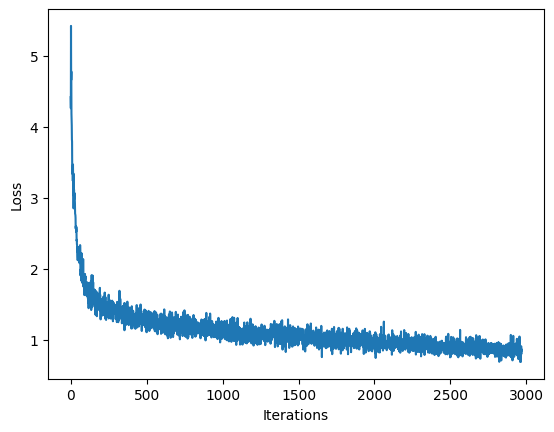

100%|██████████| 3000/3000 [01:42<00:00, 29.16it/s]
COMET INFO: Uploading 70 metrics, params and output messages


True

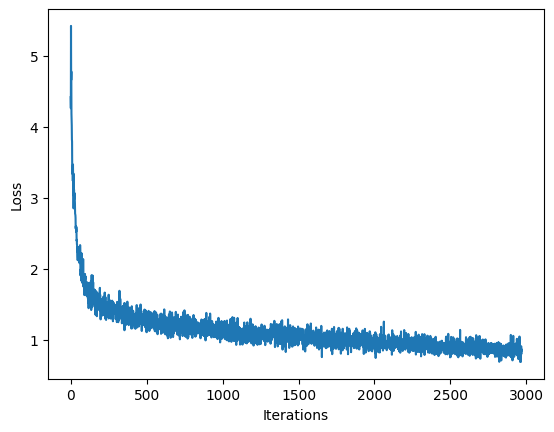

In [ ]:
### Define optimizer and training operation ###

model = build_model(vocab_size=len(vocab),
    embedding_dim=params['embedding_dim'],
    rnn_units=params['rnn_units'],
    batch_size=params['batch_size'])

optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])

@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:

    y_hat = model(x)
    loss = compute_loss(y, y_hat) #compute_loss(label, pred)

  grads = tape.gradient(loss, model.trainable_variables)

  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

#training

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
experiment = create_experiment()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for iter in tqdm(range(params["num_training_iterations"])):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, params["seq_length"], params["batch_size"])
  loss = train_step(x_batch, y_batch)

  # log the loss to the Comet interface! we will be able to track it there.
  experiment.log_metric("loss", loss.numpy().mean(), step=iter)
  # Update the progress bar and also visualize within notebook
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)

# Save the trained model and the weights
model.save_weights(checkpoint_prefix)
experiment.flush()

##Generate music using the RNN model

Now, we can use our trained RNN model to generate some music. When generating music, we'll have to feed the model some sort of seed to get it started (because it can't predict anything without something to start with).
Once we have a generated seed, we can then iteratively predict each successive character(Because we're using ABC notation).

In [ ]:

model = build_model(vocab_size=len(vocab),
                    embedding_dim=params['embedding_dim'],
                    rnn_units=params['rnn_units'],
                    batch_size=1)


# Restore the model weights for the last checkpoint after training
model.build(tf.TensorShape([1, None]))
model.load_weights(checkpoint_prefix)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (1, None, 256)         │        21,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (1, None, 1024)        │     5,246,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, None, 83)          │        85,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,353,299 (20.42 MB)

 Trainable params: 5,353,299 (20.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  input_eval = [char2idx[c] for c in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  for layer in model.layers:
    if hasattr(layer, "reset_states"):
        layer.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      predictions = model(input_eval)

      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      predicted_id = tf.random.categorical(predictions[-1:], num_samples=1)[-1,0].numpy()

      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)


      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

generated_text = generate_text(model, start_string="X", generation_length=1000)

100%|██████████| 1000/1000 [00:11<00:00, 84.09it/s]


In [ ]:
generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs):
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)

  # If its a valid song (correct syntax), lets play it!
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

    numeric_data = np.frombuffer(waveform.data, dtype=np.int16)
    wav_file_path = f"output_{i}.wav"
    write(wav_file_path, 88200, numeric_data)

    # save your song to the Comet interface -- you can access it there
    experiment.log_asset(wav_file_path)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
experiment.end()